In [6]:
# Step 1: Import Necessary Libraries
import os
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Load the Data

In [7]:
# Define the categories and their corresponding directories
categories = ['business', 'entertainment', 'politics', 'sport', 'tech']
base_dir = '/kaggle/input/bbc-full-text-document-classification/bbc/'

In [8]:
# List to hold the data
texts = []
labels = []

# Load data from each category directory
for category in categories:
    category_dir = os.path.join(base_dir, category)
    
    for filename in os.listdir(category_dir):
        if filename.endswith(".txt"):  # Read only text files
            file_path = os.path.join(category_dir, filename)
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                texts.append(file.read())
                labels.append(category)

# Create a Pandas DataFrame to store the text and corresponding labels
data = pd.DataFrame({'text': texts, 'category': labels})

# Check the first few rows of the dataset
print(data.head())

                                                text  category
0  US consumer confidence up\n\nConsumers' confid...  business
1  The 'ticking budget' facing the US\n\nThe budg...  business
2  Mitsubishi in Peugeot link talks\n\nTrouble-hi...  business
3  BMW reveals new models pipeline\n\nBMW is prep...  business
4  World leaders gather to face uncertainty\n\nMo...  business


In [9]:
print(data.tail())

                                                   text category
2220  Sun offers processing by the hour\n\nSun Micro...     tech
2221  Mobile gaming takes off in India\n\nGaming on ...     tech
2222  Apple sues to stop product leaks\n\nComputer f...     tech
2223  Digital guru floats sub-$100 PC\n\nNicholas Ne...     tech
2224  Game firm holds 'cast' auditions\n\nVideo game...     tech


# Exploratory Data Analysis (EDA)

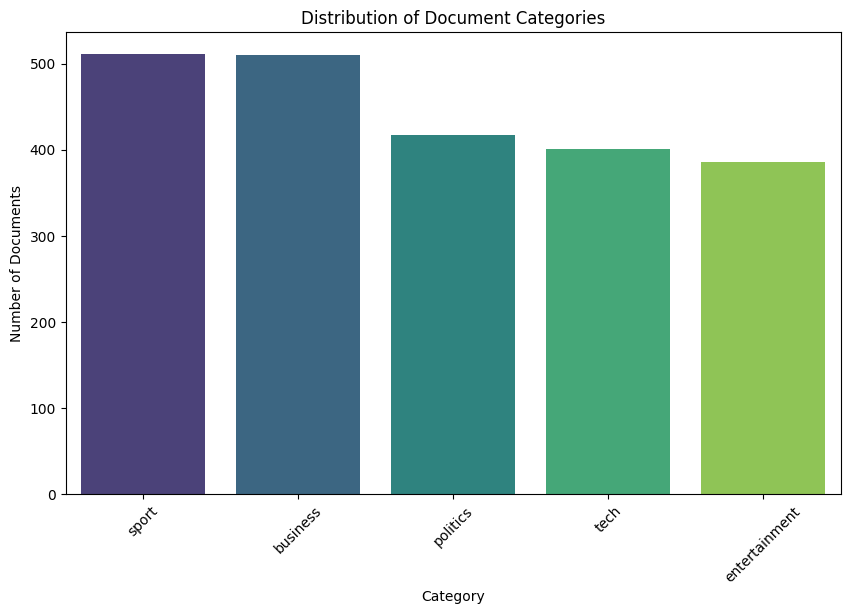

In [10]:
# Section 3: Exploratory Data Analysis (EDA)

# Category Distribution
category_counts = data['category'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribution of Document Categories')
plt.xlabel('Category')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.show()


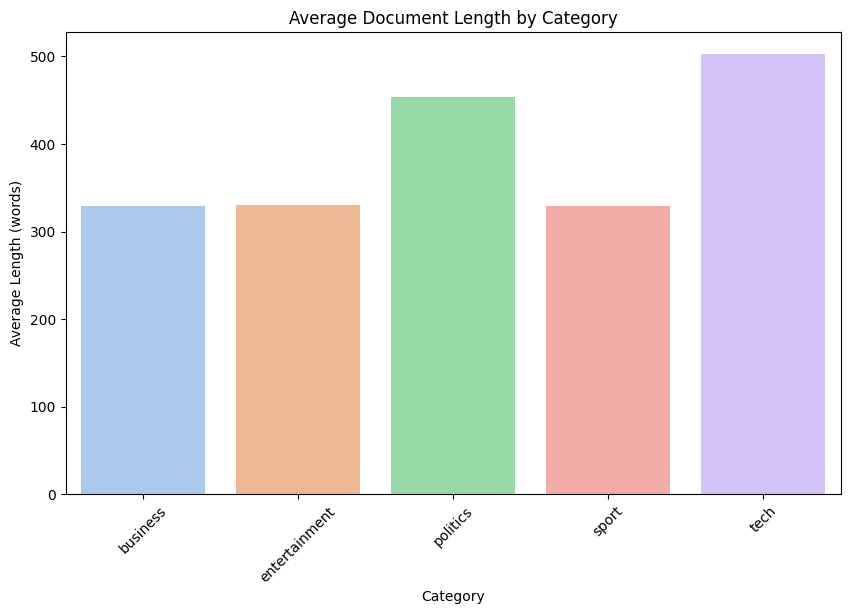

In [11]:
# Average Document Length
data['length'] = data['text'].apply(lambda x: len(x.split()))
average_length = data.groupby('category')['length'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=average_length.index, y=average_length.values, palette='pastel')
plt.title('Average Document Length by Category')
plt.xlabel('Category')
plt.ylabel('Average Length (words)')
plt.xticks(rotation=45)
plt.show()


In [12]:
# Sample Documents
def print_sample_documents(data, category, num_samples=2):
    print(f"\nSample documents from category: {category}")
    samples = data[data['category'] == category].sample(num_samples)
    for index, row in samples.iterrows():
        print(f"Document:\n{row['text'][:200]}...")  # Print first 200 characters
        print("\n")

for category in categories:
    print_sample_documents(data, category)


Sample documents from category: business
Document:
Russia gets investment blessing

Soaring oil sales and a budget surplus mean Russian debt is no longer a risky investment, one of the world's leading credit rating agencies says.

Standard & Poor's ha...


Document:
Japan economy slides to recession

The Japanese economy has officially gone back into recession for the fourth time in a decade.

Gross domestic product fell by 0.1% in the last three months of 2004. ...



Sample documents from category: entertainment
Document:
Disputed Nirvana box set on sale

A box set featuring 68 unreleased Nirvana tracks has gone on sale in the US, after years of legal wrangles.

With the Lights Out was intended to be released in 2001, ...


Document:
Moreno debut makes Oscar mark

Catalina Sandino Moreno has joined a rare group of actresses who have been nominated for an Oscar for starring in a foreign language film.

The Colombian-born actress wa...



Sample documents from category: politics
Docum

# Preprocess the Text

In [13]:
nltk.download('punkt') # pre-trained model that can split text into words
nltk.download('stopwords')

# Preprocess function
def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    tokens = word_tokenize(text)  # split into words
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

# Apply preprocessing to the text column
data['cleaned_text'] = data['text'].apply(preprocess_text)

# Check the cleaned data
print(data['cleaned_text'].head())


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0    us consumer confidence consumers confidence st...
1    ticking budget facing us budget proposals laid...
2    mitsubishi peugeot link talks trouble hit mits...
3    bmw reveals new models pipeline bmw preparing ...
4    world leaders gather face uncertainty 2 000 bu...
Name: cleaned_text, dtype: object


# Convert Text to Numerical Representation (TF-IDF)

In [14]:
# Convert text to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')  # Limiting to 5000 features
X = tfidf.fit_transform(data['cleaned_text'])

# Check shape of the transformed data
print(X.shape)  # (number of documents, 5000 features)


(2225, 5000)


# Split the Data

In [15]:
# Target variable
y = data['category']

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check the size of training and test sets
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (1557, 5000)
Test set size: (668, 5000)


# Select and Train a Classification Model

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1,0.5, 10],
    'kernel': ['linear', 'rbf','poly'],  # You can add 'poly', 'sigmoid' if desired
    'gamma': ['scale', 'auto']  
}

In [17]:
# Create the SVM model
svm_model = SVC()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=svm_model,
                           param_grid=param_grid,
                           scoring='accuracy',  
                           cv=5,  
                           verbose=1,  # Show progress
                           n_jobs=-1)  # Use all available cores

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}


# Evaluate the Model

In [18]:
# Get the best model from grid search
best_svm_model = grid_search.best_estimator_

# Predict
y_pred = best_svm_model.predict(X_test)

# You can now evaluate the performance with the predictions
from sklearn.metrics import classification_report

print("Classification Report for Optimized SVM:")
print(classification_report(y_test, y_pred))


Classification Report for Optimized SVM:
               precision    recall  f1-score   support

     business       0.98      0.95      0.96       165
entertainment       0.98      1.00      0.99       118
     politics       0.94      0.96      0.95       120
        sport       0.99      0.99      0.99       140
         tech       0.98      0.99      0.98       125

     accuracy                           0.98       668
    macro avg       0.98      0.98      0.98       668
 weighted avg       0.98      0.98      0.98       668



In [19]:
# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[156   0   7   0   2]
 [  0 118   0   0   0]
 [  2   1 115   1   1]
 [  1   0   0 139   0]
 [  0   1   0   0 124]]


# Detailed Error Analysis

In [20]:
# Section 9: Detailed Error Analysis
# Get the indices of the misclassified samples
misclassified_indices = [i for i in range(len(y_pred)) if y_pred[i] != y_test.iloc[i]]

# Use the original indices from y_test to access the misclassified rows
misclassified = data.iloc[y_test.index[misclassified_indices]]

print("Misclassified Samples:")
for i, index in enumerate(misclassified_indices):
    # Access the predicted class using the misclassified index
    print(f"Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}")
    print(f"Document: {misclassified.iloc[i]['text'][:200]}...")  # Show the first 200 characters
    print("-" * 80)


Misclassified Samples:
Actual: business, Predicted: politics
Document: UK young top Euro earnings league

British children enjoy the highest average annual income in Europe - more than double that of Spanish or Italian youngsters, a report suggests.

Children in the UK b...
--------------------------------------------------------------------------------
Actual: sport, Predicted: business
Document: Ferdinand casts doubt over Glazer

Rio Ferdinand has said he is unsure of Malcolm Glazer's motives after the American billionaire launched a new offer to buy Manchester United.

The club have confirme...
--------------------------------------------------------------------------------
Actual: politics, Predicted: entertainment
Document: Drive to 'save' festive holidays

Efforts are being made to 'protect' workers' days off on Christmas Day and New Year's Day.

Support is being sought for a bill which would ensure that large retailers...
---------------------------------------------------------

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Preprocess Text Data for RNN/LSTM

In [22]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['cleaned_text'])

# Convert texts to sequences
X_seq = tokenizer.texts_to_sequences(data['cleaned_text'])

# Pad sequences to ensure uniform input length
max_length = max(len(seq) for seq in X_seq)  
X_padded = pad_sequences(X_seq, maxlen=max_length, padding='post')

# Convert labels to numeric values
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the padded data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.3, random_state=42)


# Build the RNN Model

In [40]:
# Define model architecture
rnn_model = Sequential()

# Embedding layer: Convert words to dense vectors
rnn_model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))

# First LSTM layer (Bidirectional for better context understanding)
rnn_model.add(Bidirectional(LSTM(128, return_sequences=True)))

# Second LSTM layer
rnn_model.add(Bidirectional(LSTM(128, return_sequences=True)))

# Third LSTM layer
rnn_model.add(Bidirectional(LSTM(128, return_sequences=False)))

# First Dense layer for classification
rnn_model.add(Dense(64, activation='relu'))  # More units for deeper learning capacity

# Add a Dropout layer to prevent overfitting
rnn_model.add(Dropout(0.5))

# Second Dense layer
rnn_model.add(Dense(32, activation='relu'))  # Another Dense layer for complexity

# Third Dense layer (optional)
rnn_model.add(Dense(16, activation='relu'))  # Additional Dense layer

# Output layer with softmax activation for multiclass classification
rnn_model.add(Dense(5, activation='softmax'))

# Compile the model with Adam optimizer and sparse_categorical_crossentropy loss function
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = rnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 763ms/step - accuracy: 0.2405 - loss: 1.5650 - val_accuracy: 0.3877 - val_loss: 1.2357
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 751ms/step - accuracy: 0.4868 - loss: 1.0595 - val_accuracy: 0.5344 - val_loss: 1.0033
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 751ms/step - accuracy: 0.6459 - loss: 0.8545 - val_accuracy: 0.6826 - val_loss: 0.7892
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 751ms/step - accuracy: 0.7459 - loss: 0.5648 - val_accuracy: 0.7440 - val_loss: 0.5431
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 751ms/step - accuracy: 0.7866 - loss: 0.4035 - val_accuracy: 0.7081 - val_loss: 0.5839
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 751ms/step - accuracy: 0.8086 - loss: 0.3646 - val_accuracy: 0.7680 - val_loss: 0.6012
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 752ms/step - accuracy: 0.8385 - loss: 0.3250 - val_accuracy: 0.7829 - val_loss: 0.6723
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 751ms/step - accuracy: 0.9485 - loss: 0.1627 - val_accu

# Build the LSTM Model

In [58]:
# Define the LSTM model architecture
lstm_model = Sequential()

# Embedding layer: Convert words to dense vectors
lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))  # Increased output_dim

# First Bidirectional LSTM layer
lstm_model.add(Bidirectional(LSTM(128, return_sequences=True))) 
lstm_model.add(Bidirectional(LSTM(128, return_sequences=True))) 


# Second Bidirectional LSTM layer

lstm_model.add(Bidirectional(LSTM(128, return_sequences=False))) 

# First Dense layer for classification
lstm_model.add(Dense(64, activation='relu'))  # Increased number of units for capacity

# Add a Dropout layer to prevent overfitting
lstm_model.add(Dropout(0.5))

# Second Dense layer
lstm_model.add(Dense(32, activation='relu'))  # Another layer for complexity
lstm_model.add(Dropout(0.3))

# Third Dense layer (optional)
lstm_model.add(Dense(16, activation='relu'))  # Additional Dense layer for deeper learning

lstm_model.add(Dropout(0.3))

# Output layer with softmax activation for multiclass classification
lstm_model.add(Dense(5, activation='softmax'))

# Compile the model with Adam optimizer and sparse_categorical_crossentropy loss function
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 765ms/step - accuracy: 0.1805 - loss: 1.6123 - val_accuracy: 0.3144 - val_loss: 1.5821
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 753ms/step - accuracy: 0.2892 - loss: 1.5168 - val_accuracy: 0.2515 - val_loss: 1.5881
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 754ms/step - accuracy: 0.2636 - loss: 1.5663 - val_accuracy: 0.4386 - val_loss: 1.3121
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 754ms/step - accuracy: 0.4239 - loss: 1.2718 - val_accuracy: 0.6302 - val_loss: 1.0631
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 754ms/step - accuracy: 0.5129 - loss: 1.1054 - val_accuracy: 0.5599 - val_loss: 1.0261
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 753ms/step - accuracy: 0.5613 - loss: 0.9914 - val_accuracy: 0.5823 - val_loss: 0.9311
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 753ms/step - accuracy: 0.6189 - loss: 0.8568 - val_accuracy: 0.5509 - val_loss: 0.9624
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 753ms/step - accuracy: 0.5894 - loss: 0.8751 - val_accu

# Evaluate the Models

In [48]:
# Evaluate RNN Model
rnn_y_pred = rnn_model.predict(X_test)
rnn_y_pred_classes = np.argmax(rnn_y_pred, axis=1)
print("RNN Classification Report:")
print(classification_report(y_test, rnn_y_pred_classes))



21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step
RNN Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       165
           1       0.93      0.92      0.93       118
           2       0.96      0.90      0.93       120
           3       1.00      0.98      0.99       140
           4       0.87      0.94      0.90       125

    accuracy                           0.93       668
   macro avg       0.93      0.93      0.93       668
weighted avg       0.93      0.93      0.93       668



In [59]:
# Evaluate LSTM Model
lstm_y_pred = lstm_model.predict(X_test)
lstm_y_pred_classes = np.argmax(lstm_y_pred, axis=1)
print("LSTM Classification Report:")
print(classification_report(y_test, lstm_y_pred_classes))

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       165
           1       0.96      0.87      0.92       118
           2       0.90      0.95      0.93       120
           3       0.99      0.99      0.99       140
           4       0.85      0.88      0.86       125

    accuracy                           0.92       668
   macro avg       0.92      0.92      0.92       668
weighted avg       0.92      0.92      0.92       668



# Visualize Confusion Matrix

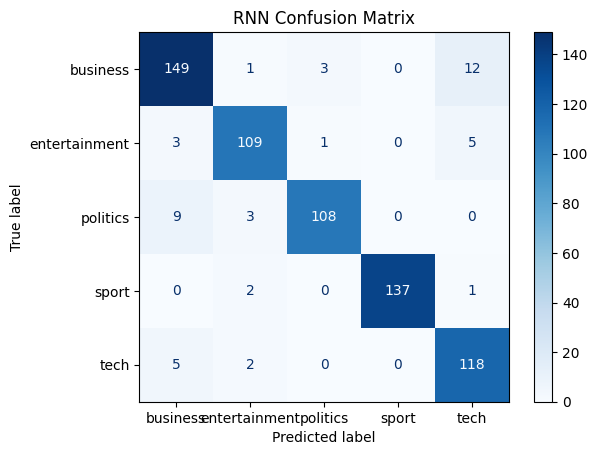

In [50]:
# Confusion Matrix for RNN
rnn_conf_matrix = confusion_matrix(y_test, rnn_y_pred_classes)
ConfusionMatrixDisplay(rnn_conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.title('RNN Confusion Matrix')
plt.show()



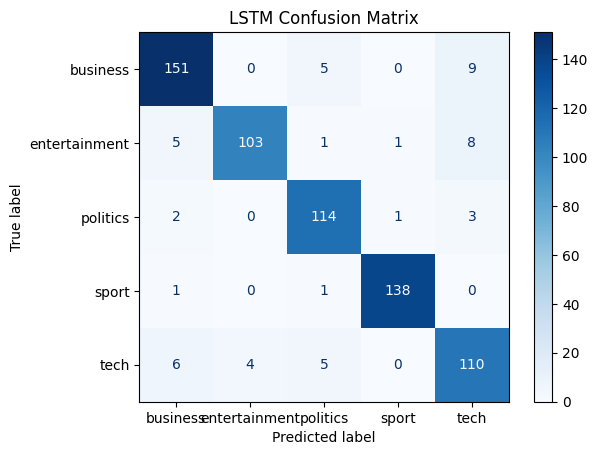

In [60]:
# Confusion Matrix for LSTM
lstm_conf_matrix = confusion_matrix(y_test, lstm_y_pred_classes)
ConfusionMatrixDisplay(lstm_conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.show()
